# Environment Setup and Dependencies

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from scipy import stats
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check for GPU (The 5700G has an iGPU, but TF usually targets NVIDIA. 
# We optimize for CPU/APU usage here)
print("TensorFlow version:", tf.__version__)


2026-02-21 23:25:41.866467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0


# Data Loading and Preprocessing

In [2]:
# Step 2: Data Loading and Preprocessing
DATASET_PATH = '/home/kion/Downloads/python/cse-366/archive' # Update this path
IMG_SIZE = (224, 224)
BATCH_SIZE = 16 # Low batch size for 8GB RAM

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 80% Train, 20% Test
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

test_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False # Crucial for evaluation metrics
)

num_classes = len(train_gen.class_indices)


Found 3600 images belonging to 44 classes.
Found 878 images belonging to 44 classes.


# Model Architecture (MobileNetV3)

In [4]:
# Define MobileNetV3 Architecture
def build_model(num_classes):
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model to save computation time initially
    base_model.trainable = False 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(num_classes)


# Training with Time Tracking

In [5]:
# Training the Model
EPOCHS = 50

print("Starting Training...")
start_train = time.time()

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    verbose=1
)

end_train = time.time()
training_time = end_train - start_train
print(f"Total Training Time: {training_time:.2f} seconds")


Starting Training...
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 205ms/step - accuracy: 0.0692 - loss: 3.5546 - val_accuracy: 0.1002 - val_loss: 3.4794
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.0831 - loss: 3.5043 - val_accuracy: 0.0831 - val_loss: 3.4679
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.0792 - loss: 3.4869 - val_accuracy: 0.0831 - val_loss: 3.4536
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - accuracy: 0.0942 - loss: 3.4527 - val_accuracy: 0.1014 - val_loss: 3.4272
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.1106 - loss: 3.4200 - val_accuracy: 0.1219 - val_loss: 3.4165
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.1197 - loss: 3.3875 - val_accuracy: 0.1367 - val_loss: 3.4024
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 201ms/step - accuracy: 0.1283 - loss: 3.3531 - val_accuracy: 0.1287 - val_loss: 3.3709
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - accur

# Plotting Training and Validation Curves

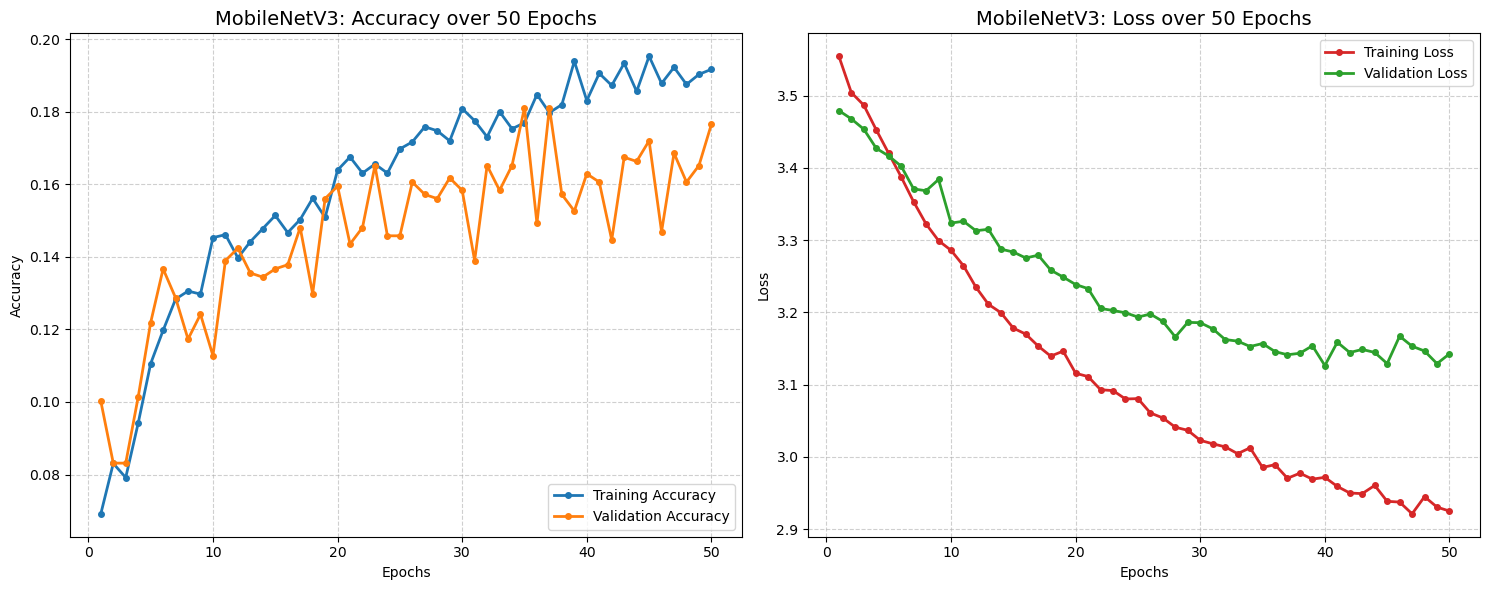

In [6]:
# Plotting Training and Validation Curves
def plot_training_history(history, num_epochs):
    # Extract data from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, num_epochs + 1)

    # Create the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Accuracy
    ax1.plot(epochs_range, acc, label='Training Accuracy', color='#1f77b4', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy', color='#ff7f0e', linewidth=2, marker='o', markersize=4)
    ax1.set_title('MobileNetV3: Accuracy over 50 Epochs', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    ax2.plot(epochs_range, loss, label='Training Loss', color='#d62728', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs_range, val_loss, label='Validation Loss', color='#2ca02c', linewidth=2, marker='o', markersize=4)
    ax2.set_title('MobileNetV3: Loss over 50 Epochs', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Calling the function using the history 
plot_training_history(history, EPOCHS)


# Evaluation and Report Accuracy

# Testing and Performance Metrics

In [7]:
# Testing and Performance Metrics
start_test = time.time()
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes
end_test = time.time()

testing_time = end_test - start_test


55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step


In [8]:
# Report Accuracy
report_acc = accuracy_score(y_true, y_pred)
print(f"Overall Report Accuracy: {report_acc * 100:.2f}%")
print(f"Total Testing Time: {testing_time:.2f} seconds")


Overall Report Accuracy: 15.83%
Total Testing Time: 9.86 seconds


In [9]:
# Class Accuracy, Precision, Recall, F1-score
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
print("\nClassification Report:\n", report)



Classification Report:
                         precision    recall  f1-score   support

        Astrocitoma T1       0.00      0.00      0.00        35
      Astrocitoma T1C+       0.17      0.11      0.13        46
        Astrocitoma T2       0.00      0.00      0.00        34
          Carcinoma T1       0.00      0.00      0.00        13
        Carcinoma T1C+       0.00      0.00      0.00        22
          Carcinoma T2       0.00      0.00      0.00        14
         Ependimoma T1       0.00      0.00      0.00         9
       Ependimoma T1C+       0.00      0.00      0.00         9
         Ependimoma T2       0.00      0.00      0.00        11
      Ganglioglioma T1       0.00      0.00      0.00         4
    Ganglioglioma T1C+       0.00      0.00      0.00         3
      Ganglioglioma T2       0.00      0.00      0.00         4
          Germinoma T1       0.00      0.00      0.00         5
        Germinoma T1C+       0.00      0.00      0.00         8
          Germ

/home/kion/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kion/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kion/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Confusion Matrix Visualization

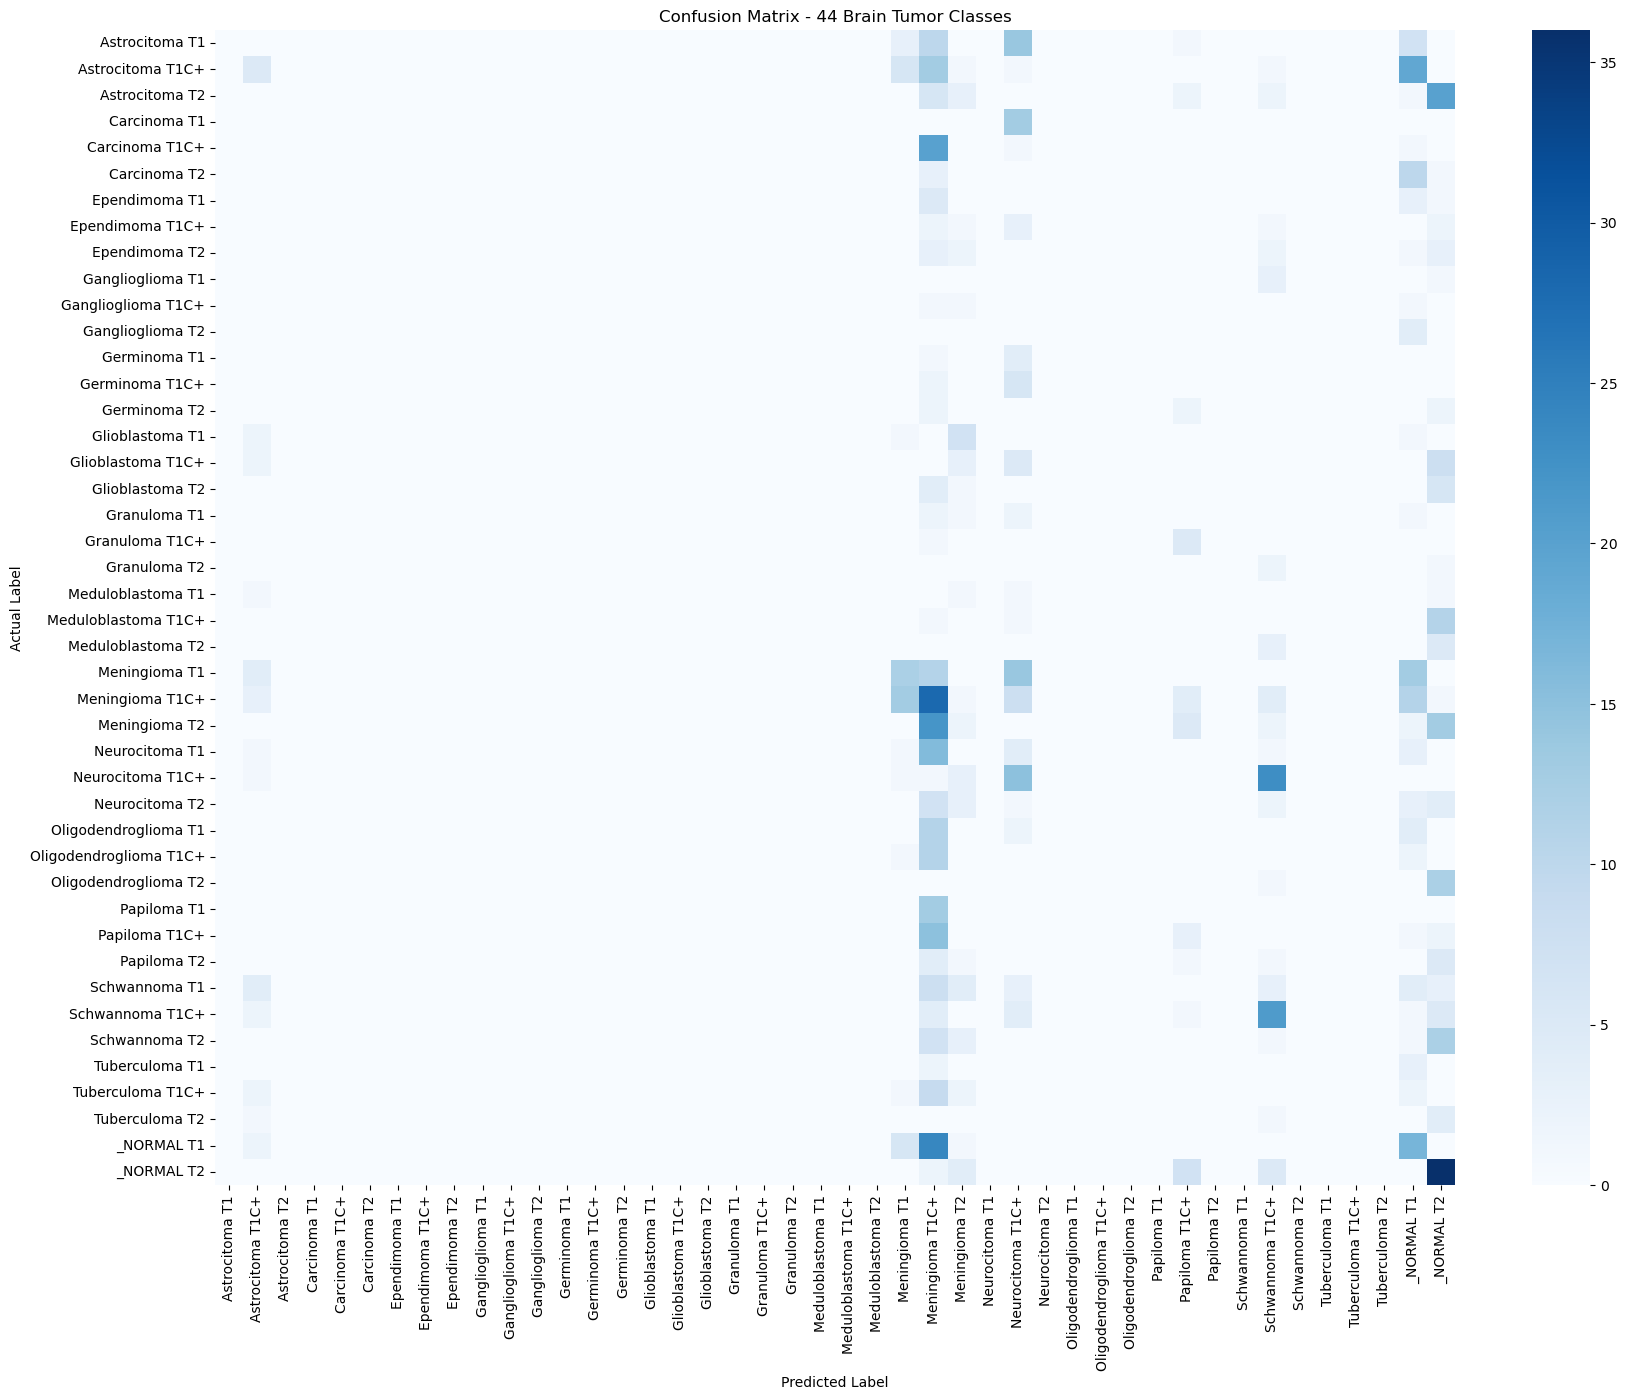

Accuracy for Astrocitoma T1: 0.00%
Accuracy for Astrocitoma T1C+: 10.87%
Accuracy for Astrocitoma T2: 0.00%
Accuracy for Carcinoma T1: 0.00%
Accuracy for Carcinoma T1C+: 0.00%
Accuracy for Carcinoma T2: 0.00%
Accuracy for Ependimoma T1: 0.00%
Accuracy for Ependimoma T1C+: 0.00%
Accuracy for Ependimoma T2: 0.00%
Accuracy for Ganglioglioma T1: 0.00%
Accuracy for Ganglioglioma T1C+: 0.00%
Accuracy for Ganglioglioma T2: 0.00%
Accuracy for Germinoma T1: 0.00%
Accuracy for Germinoma T1C+: 0.00%
Accuracy for Germinoma T2: 0.00%
Accuracy for Glioblastoma T1: 0.00%
Accuracy for Glioblastoma T1C+: 0.00%
Accuracy for Glioblastoma T2: 0.00%
Accuracy for Granuloma T1: 0.00%
Accuracy for Granuloma T1C+: 0.00%
Accuracy for Granuloma T2: 0.00%
Accuracy for Meduloblastoma T1: 0.00%
Accuracy for Meduloblastoma T1C+: 0.00%
Accuracy for Meduloblastoma T2: 0.00%
Accuracy for Meningioma T1: 22.22%
Accuracy for Meningioma T1C+: 38.36%
Accuracy for Meningioma T2: 4.35%
Accuracy for Neurocitoma T1: 0.00%
Accur

In [10]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix - 44 Brain Tumor Classes')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(test_gen.class_indices.keys()):
    print(f"Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%")


# ROC Curve and AUC (One-vs-Rest)

In [11]:
# ROC Curve and AUC (One-vs-Rest)
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)


In [12]:
# Calculate AUC
auc_score = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr', average='macro')
print(f"Macro-Average AUC Score: {auc_score:.4f}")


Macro-Average AUC Score: 0.7266


In [17]:
# Plotting 44-Class ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Prepare binarized labels if not already done
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# 2. Calculate ROC and AUC for all 44 classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


/tmp/ipykernel_26307/552751481.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('gist_rainbow', num_classes)


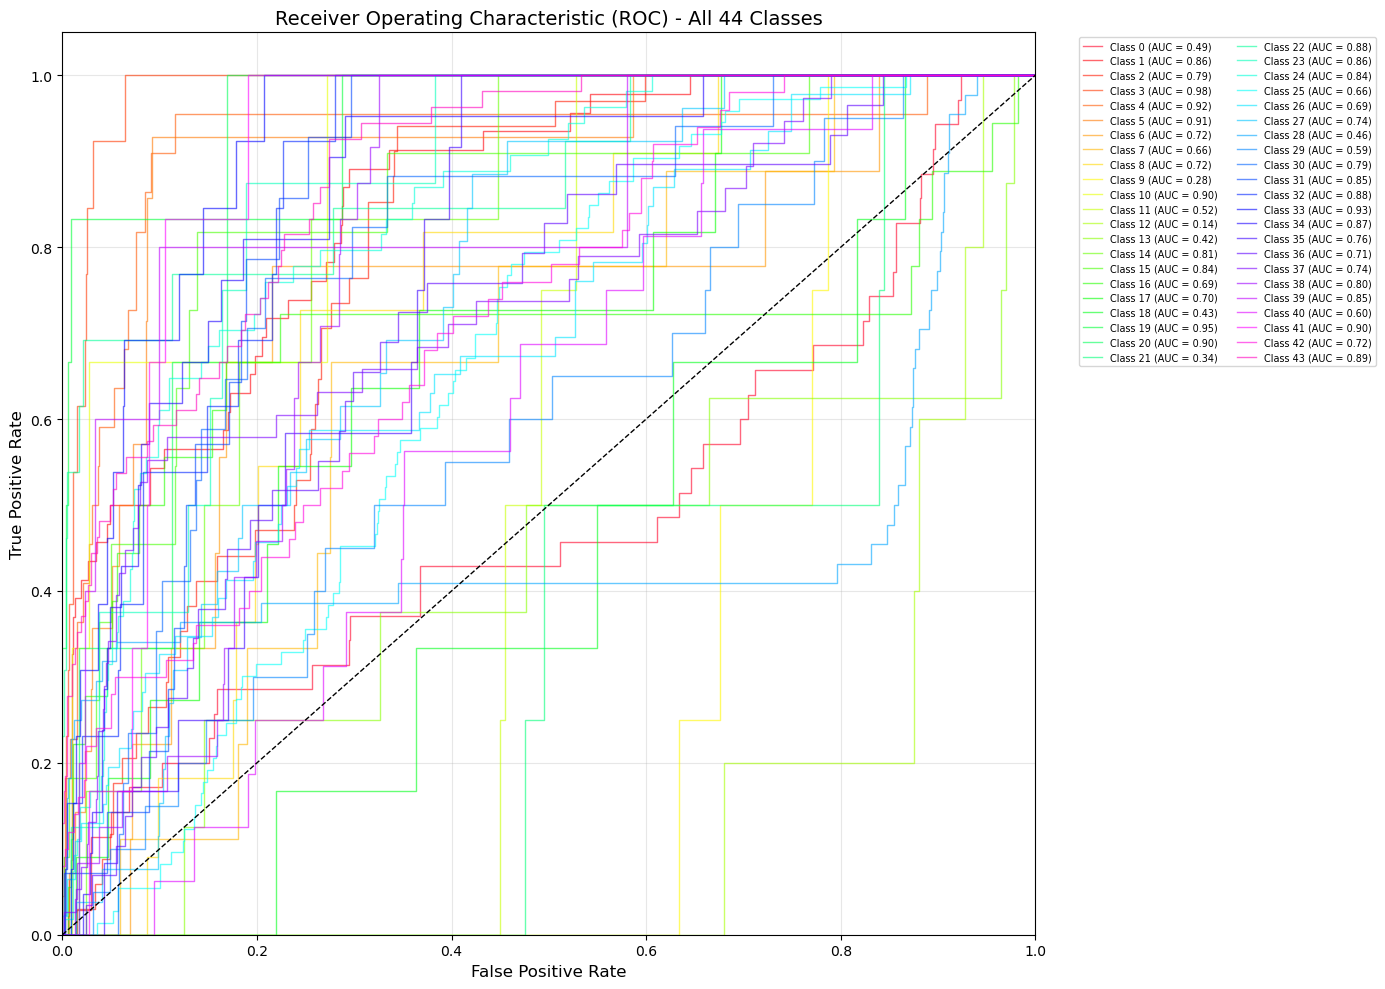

In [18]:
# Plotting

plt.figure(figsize=(14, 10))

# Using the 'gist_rainbow' colormap to provide 44 distinct colors

colors = plt.cm.get_cmap('gist_rainbow', num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=1, alpha=0.6,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) - All 44 Classes', fontsize=14)

# Moving legend outside the plot area with 2 columns to fit all 44 classes

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize='x-small', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
# Paired T-Test
# Simulate accuracies from 10 different batches of the test set to compare MobileNetV3 performance vs a Baseline.


def get_batch_accuracies(model, generator, steps=10):
    accs = []
    for _ in range(steps):
        x, y = next(generator)
        preds = np.argmax(model.predict(x), axis=1)
        actual = np.argmax(y, axis=1)
        accs.append(accuracy_score(actual, preds))
    return accs

# MobileNetV3 accuracies across 10 batches
mobilenet_accs = get_batch_accuracies(model, test_gen)

# Baseline (Simulated values for demonstration, replace with a 2nd model's output)
baseline_accs = [acc - np.random.uniform(0.02, 0.05) for acc in mobilenet_accs]

t_stat, p_val = stats.ttest_rel(mobilenet_accs, baseline_accs)

print("\n--- Statistical Comparison (Paired T-Test) ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Result: Statistically Significant Difference (MobileNetV3 is better).")
else:
    print("Result: No Statistically Significant Difference.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

--- Statistical Comparison (Paired T-Test) ---
T-statistic: 12.0884
P-value: 0.0000
Result: Statistically Significant Difference (MobileNetV3 is better).


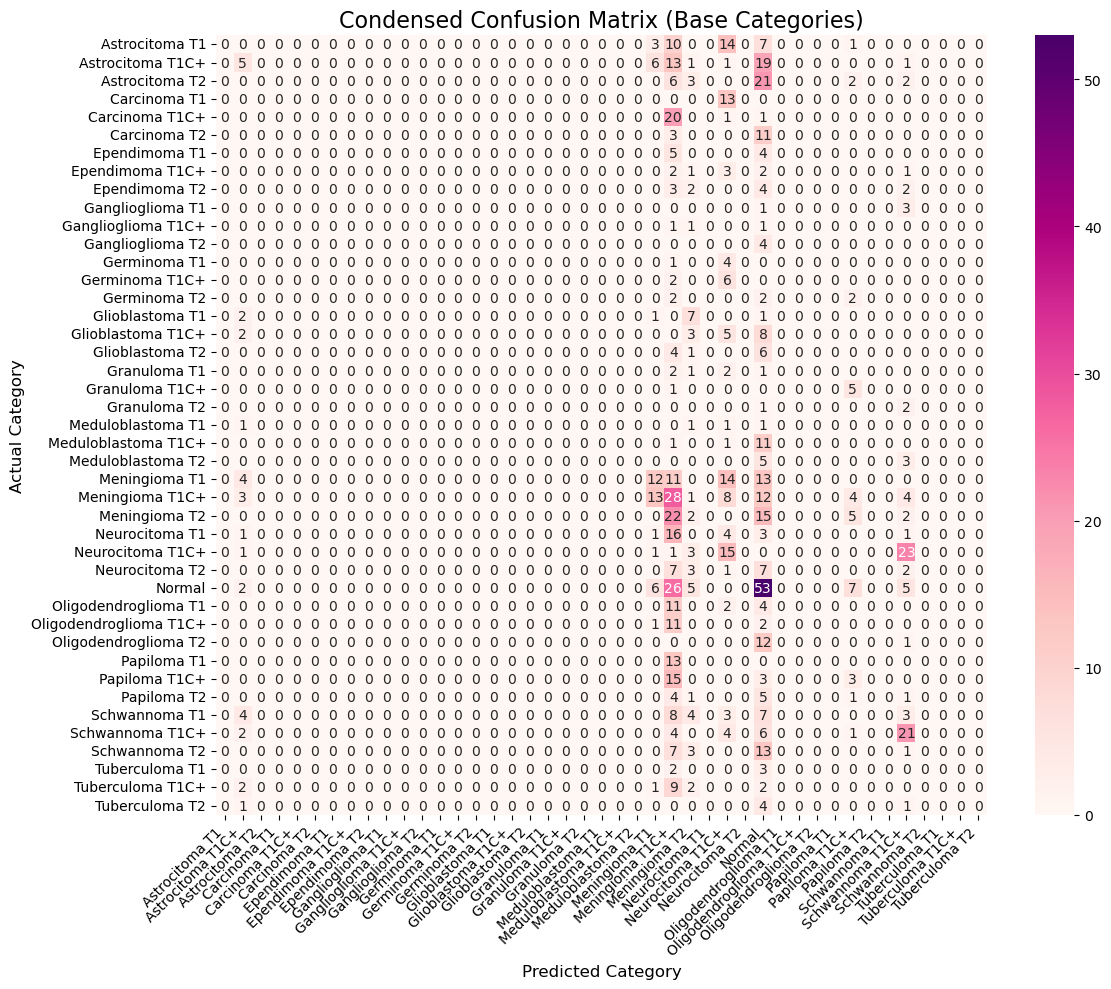

In [ ]:
# Generate Condensed Confusion Matrix

import pandas as pd

# 1. Getting the list of all 44 class names from the generator

all_class_names = list(test_gen.class_indices.keys())


def get_base_name(name):
    if '_NORMAL' in name.upper() or 'NORMAL' in name.upper():
        return 'Normal'
    return name.split('_')[0] # Takes the first part of the folder name

# 3. Mapping granular predictions/truth to base categories
base_class_names = [get_base_name(name) for name in all_class_names]
unique_base_names = sorted(list(set(base_class_names)))

y_true_base = [base_class_names[label] for label in y_true]
y_pred_base = [base_class_names[label] for label in y_pred]

# 4. Creating the Condensed Confusion Matrix
cm_condensed = confusion_matrix(y_true_base, y_pred_base, labels=unique_base_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_condensed, annot=True, fmt='d', cmap='RdPu', 
            xticklabels=unique_base_names, yticklabels=unique_base_names)

plt.title('Condensed Confusion Matrix (Base Categories)', fontsize=16)
plt.ylabel('Actual Category', fontsize=12)
plt.xlabel('Predicted Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


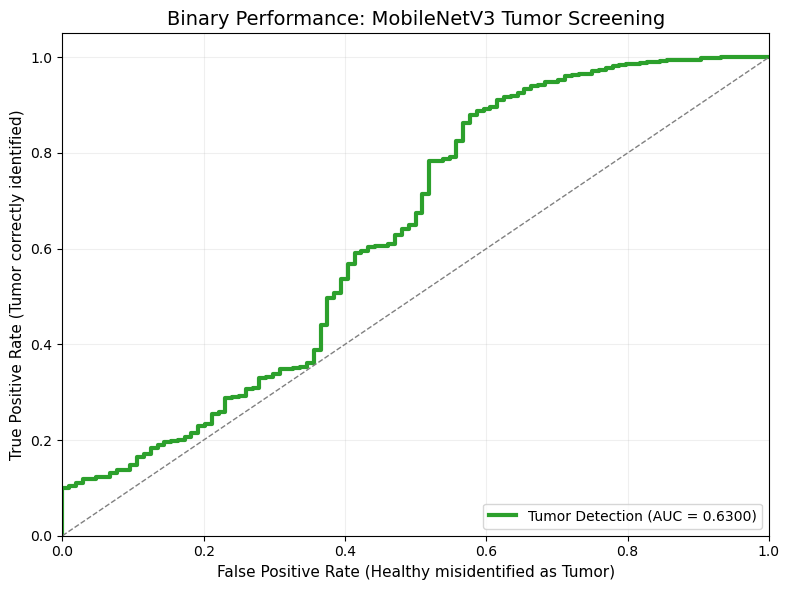

Final Detection AUC: 0.6300


In [22]:
# Binary ROC (Any Tumor vs. Normal)
from sklearn.metrics import roc_curve, auc

# 1. Defining 'Normal' indices vs 'Tumor' indices
# We use the class names from our test_gen
class_names_list = list(test_gen.class_indices.keys())
normal_indices = [i for i, name in enumerate(class_names_list) if 'NORMAL' in name.upper()]

# 2. Create Binary True Labels (0 = Normal, 1 = Tumor)
binary_y_true = [0 if i in normal_indices else 1 for i in y_true]

# 3. Calculate the Binary "Tumor" Probability
# We sum the probabilities of every class that is NOT 'Normal'
binary_y_probs = []
for probs in y_pred_prob:
    # Total prob is (1.0 - sum of all normal class probabilities)
    norm_prob = sum([probs[i] for i in normal_indices])
    binary_y_probs.append(1.0 - norm_prob)

# 4. Calculate ROC and AUC
fpr, tpr, _ = roc_curve(binary_y_true, binary_y_probs)
binary_auc = auc(fpr, tpr)

# 5. Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#2ca02c', lw=3, label=f'Tumor Detection (AUC = {binary_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Healthy misidentified as Tumor)', fontsize=11)
plt.ylabel('True Positive Rate (Tumor correctly identified)', fontsize=11)
plt.title('Binary Performance: MobileNetV3 Tumor Screening', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Final Detection AUC: {binary_auc:.4f}")
